# Quick start

In [53]:
import rectanglepy as rectangle
import pandas as pd
from anndata import AnnData, read_h5ad
import matplotlib.pyplot as plt

## Creating the input data

Rectangle requires the single-cell data in the form of a scverse [`AnnData`](https://anndata.readthedocs.io/en/latest/) object, and the bulk data as a pandas DataFrame.

Do see an example of this, we can load the tutorial data provided by Rectangle.

In [2]:
sc_counts, annotations, bulks  = rectangle.load_tutorial_data()

The tutorial data set contains single-cell RNA-seq counts as a pandas DataFrame, with the cell type annotations as a pandas Series.

In [3]:
sc_counts.iloc[:, :5].head()

,MIR1302-2HG,AL627309.1,AL627309.4,AC114498.1,AL669831.5
E2L4_GATGCTACAGGCACAA,0,0,0,0,0
L5_AACAACCAGGAACTAT,0,0,0,0,0
L5_TCCTTCTGTACTCCGG,0,0,0,0,0
L2_GCCCGAACACGTATAC,0,0,0,0,0
E2L2_ATGCATGTCACACCCT,0,0,0,0,0


In [12]:
annotations.head()

E2L4_GATGCTACAGGCACAA    Monocytes
L5_AACAACCAGGAACTAT      Monocytes
L5_TCCTTCTGTACTCCGG      Monocytes
L2_GCCCGAACACGTATAC      Monocytes
E2L2_ATGCATGTCACACCCT    Monocytes
Name: 0, dtype: object

In [13]:
bulks.T.head()

,pbmc_1,pbmc_10,pbmc_12
UBE2Q2P2,0.000000,0.081115,0.000000
SSX9,0.000000,0.000000,0.000000
CXorf67,0.118865,0.086782,0.188464
EFCAB8,0.000000,0.000000,0.031570
SPATA31B1P,0.000000,0.000000,0.000000


The count dataframe with it's annotations can easily convert to an AnnData object.


In [4]:
sc_adata = AnnData(sc_counts, obs=annotations.to_frame(name="cell_type"))

## Single step Rectangle workflow

To deconvolute the bulk data in a single step, use the "rectangle" method. This method returns a tuple of the estimated cell type proportions and the signature result.

In [ ]:
estimations, signature_result = rectangle.rectangle(sc_adata, bulks)

The rectangle method returns two objects:
1. `estimations`: a pandas DataFrame with the estimated cell type proportions for each bulk sample.
2. `signature_result`: a [`RectangleSignatureResult`](../generated/rectanglepy.pp.RectangleSignatureResult.rst) object containing  additional information about the signature and the unknown content.


In [6]:
estimations

,B cells,ILC,Monocytes,NK cells,Plasma cells,Platelet,T cells CD4 conv,T cells CD8,Tregs,mDC,pDC,Unknown
pbmc_1,0.090739,0.011386,0.229843,0.022667,0.005956,0.004898,2.833039e-02,0.162392,0.416964,0.024425,0.002401,0.000000
pbmc_10,0.110518,0.016910,0.297931,0.016344,0.000659,0.021996,8.220139e-18,0.118382,0.391830,0.020750,0.004678,0.000000
pbmc_12,0.071532,0.007335,0.225517,0.101075,0.003095,0.018637,0.000000e+00,0.275009,0.256503,0.010054,0.002985,0.028258


In [7]:
signature_result

## 2-step Rectangle workflow

Rectangle can also be run in two steps, first creating the signature and then deconvoluting the bulk data.

**1. Create Signature result**

In [ ]:
signature_result = rectangle.pp.build_rectangle_signatures(sc_adata, bulks=bulks)

This creates a [`RectangleSignatureResult`](../generated/rectanglepy.pp.RectangleSignatureResult.rst) object.

**2. Deconvolute bulk data**

We can then use the signature result to deconvolute the bulk data. This is done using the `deconvolution` method of the `RectangleSignatureResult` object.

In [ ]:
estimations, _ = rectangle.tl.deconvolution(signature_result, bulks)

This returns a pandas DataFrame with the estimated cell type proportions.

In [12]:
estimations

,B cells,ILC,Monocytes,NK cells,Plasma cells,Platelet,T cells CD4 conv,T cells CD8,Tregs,mDC,pDC,Unknown
pbmc_1,0.090739,0.011386,0.229843,0.022667,0.005956,0.004898,2.833039e-02,0.162392,0.416964,0.024425,0.002401,0.000000
pbmc_10,0.110518,0.016910,0.297931,0.016344,0.000659,0.021996,8.220139e-18,0.118382,0.391830,0.020750,0.004678,0.000000
pbmc_12,0.071532,0.007335,0.225517,0.101075,0.003095,0.018637,0.000000e+00,0.275009,0.256503,0.010054,0.002985,0.028258


# Bulk RNA-seq deconvolution

Let us now see how we can use Rectangle to deconvolute bulk RNA-seq data.
For the Bulk RNA-seq data, we will use the [Finotello](https://figshare.com/articles/dataset/Validation_real/25347757?file=44877523) dataset:

*Finotello, F. et al. Molecular and pharmacological modulators of the tumor immune contexture revealed by deconvolution of RNA-seq data. Genome Med. 11, 34 (2019)*

In [5]:
bulks_fino = pd.read_csv("../data/bulks_finotello_tpm.csv", index_col=0)
bulks_fino.head()

,pbmc_1,pbmc_10,pbmc_12,pbmc_2,pbmc_4,pbmc_5,pbmc_6,pbmc_7,pbmc_9
UBE2Q2P2,0.000000,0.081115,0.000000,0.000000,0.059691,0.613015,0.0,0.000000,0.000000
SSX9,0.000000,0.000000,0.000000,0.000000,0.212565,0.000000,0.0,0.000000,0.000000
CXorf67,0.118865,0.086782,0.188464,0.094006,0.496705,0.196090,0.0,0.165406,0.157926
EFCAB8,0.000000,0.000000,0.031570,0.004499,0.346400,0.385828,0.0,0.048187,0.041571
SPATA31B1P,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


For the single-cell data, we select a [subset](https://figshare.com/articles/dataset/Training_sc/25348051?file=56063936) of the Hao CITE-seq single-cell dataset from human peripheral blood mononuclear cells (PBMC):

*Hao Y, Hao S, Andersen-Nissen E, Mauck WM 3rd, Zheng S, Butler A, et al. Integrated analysis of multimodal single-cell data. Cell. 2021;184:3573–87.e29.*

In [11]:
haoSub_adata = read_h5ad("../data/haoSub_adata.h5ad")
haoSub_adata

AnnData object with n_obs × n_vars = 14744 × 24049
    obs: 'cell_type'

We can use the `rectangle` method to deconvolute the bulk data using the single-cell data.

In [ ]:
estimations, signature_result = rectangle.rectangle(haoSub_adata, bulks_fino.T)

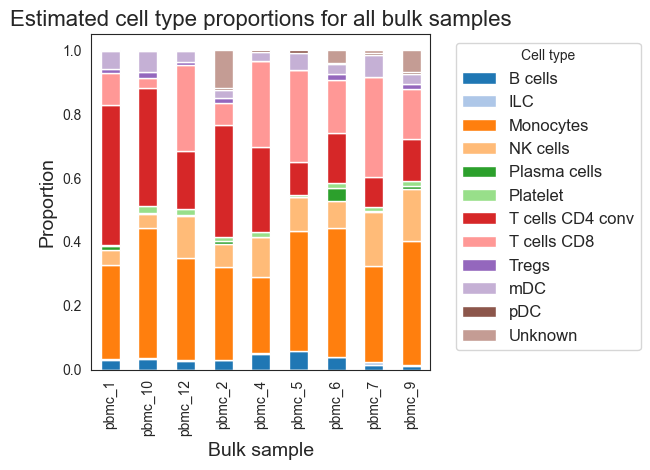

In [60]:


fig, ax = plt.subplots()
colors = plt.get_cmap('tab20').colors  # More distinct colors
estimations.plot(kind='bar', stacked=True, ax=ax, color=colors)
ax.set_title('Estimated cell type proportions for all bulk samples', fontsize=16)
ax.set_ylabel('Proportion', fontsize=14)
ax.set_xlabel('Bulk sample', fontsize=14)
ax.legend(title='Cell type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

Though the following code is not unique to Rectangle, it is useful in real world scenarios to evaluate the estimation performance.

So let us further explore the  estimation performance by plotting the estimated cell type proportions against the [true cell type proportions](https://figshare.com/articles/dataset/Validation_real/25347757?file=44877526).


In [47]:
finotello_true = pd.read_csv('../data/finotello_facs.csv', index_col=0).T
finotello_true = finotello_true.fillna(0)
finotello_true.columns = ["NK cells", 'B cells', 'Tregs', 'mDC', 'Monocytes', 'Neutrophils', 'T cells CD8',
                         'T cells CD4 conv', 'Other']

First we need to do some data wrangling to make the data compatible.


In [48]:
def match_dfs(df1, df2):
    common_rows = df1.index.intersection(df2.index)
    common_cols = df1.columns.intersection(df2.columns)
    df1_matched = df1.loc[common_rows, common_cols].sort_index().sort_index(axis=1)
    df2_matched = df2.loc[common_rows, common_cols].sort_index().sort_index(axis=1)
    return df1_matched, df2_matched

def create_evaluation_df(expected_df, estimated_df):
    evalutation_df = expected_df.T.melt()
    estimated_df_e = estimated_df.T.melt()
    evalutation_df['result'] = estimated_df_e['value']
    evalutation_df.columns = ['Cell type','True Fractions' , 'Estimated Fractions']
    return evalutation_df

true_m, finotello_m = match_dfs(finotello_true.T, estimations.T)
true_m = true_m.sort_index(key=lambda x: x.str.lower())
finotello_m = finotello_m.sort_index(key=lambda x: x.str.lower())

evaluation_df = create_evaluation_df(true_m, finotello_m)


Next we calculate some perfomance metrics to evaluate the estimation performance.
and plot the results.

<Axes: xlabel='True Fractions', ylabel='Estimated Fractions'>

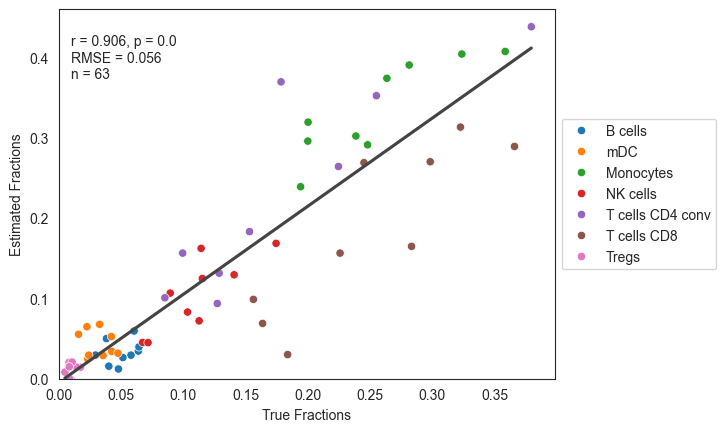

In [49]:
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns

def evaulate_total_df(df):
    rsme_total = np.sqrt(np.mean((df['Estimated Fractions'] - df['True Fractions']) ** 2))
    r_value_total, p_value_total =  pearsonr(df['Estimated Fractions'], df['True Fractions'])
    return rsme_total, r_value_total, p_value_total

rsme_finotello_rectangle, r_finotello_rectangle, p_finotello_rectangle = evaulate_total_df(evaluation_df)

def create_scatter_plot_total(df, rsme, p_value, r_value, title="Total", y_axis_label="Estimated Fractions", x_axis_label="True Fractions", hue="Cell type"):
    sns.set_style("white")
    g = sns.scatterplot(x="True Fractions", y="Estimated Fractions",hue=hue, data=df)
    sns.regplot(x="True Fractions", y="Estimated Fractions", data=df, scatter=False, color='#444444', ci=None)
    text = f"r = {round(r_value, 3)}, p = {round(p_value, 10)} \nRMSE = {round(rsme, 3)}\nn = {len(df)}"
    g.set(xlabel=x_axis_label, ylabel=y_axis_label)
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    g.annotate(text, xy=(0.01, 0.95), xycoords="axes fraction",
                xytext=(5, -5), textcoords="offset points",
                ha="left", va="top")
    g.set_xlim(0, g.get_xlim()[1])
    g.set_ylim(0, g.get_ylim()[1])
    return g

rsme_finotello_rectangle, r_finotello_rectangle, p_finotello_rectangle = evaulate_total_df(evaluation_df)
create_scatter_plot_total(evaluation_df, rsme_finotello_rectangle, p_finotello_rectangle, r_finotello_rectangle)

# Spatial transcriptomics deconvolution

To see how Rectangle can be used with spatial data, we can load a remote dataset using the `spatialdata` package.
See the [spatialdata documentation](https://spatialdata.scverse.org/en/stable/index.html) for more details.

We use the [10x Visium data generated from the human dorsolateral prefrontal cortex](https://github.com/LieberInstitute/HumanPilot/tree/master/10X/151673)

Which can be dowloaded from here:
[https://spatial-dlpfc.s3.us-east-2.amazonaws.com/h5/151673_filtered_feature_bc_matrix.h5](https://spatial-dlpfc.s3.us-east-2.amazonaws.com/h5/151673_filtered_feature_bc_matrix.h5)

In [ ]:
import spatialdata
import spatialdata_io

s_data = spatialdata_io.visium(path='../data', dataset_id='151673',scalefactors_file='scalefactors_json.json', tissue_positions_file='tissue_positions.csv', counts_file='151673_filtered_feature_bc_matrix.h5')


 To build the signature we will load the [M1 Allen Brain atlas](https://portal.brain-map.org/atlases-and-data/rnaseq/human-m1-10x)

In [ ]:
counts = pd.read_csv('../data/human_m1/matrix.csv', index_col=0)
counts = counts.astype(int)
metadata = pd.read_csv('../data/human_m1/metadata.csv', index_col=0)
annotations = metadata['cell_type_alias_label']


We do a simple preprocessing of the annotations to group the cell types into broader categories.

In [ ]:
# remove anything after the second space(word)
annotations = annotations.str.split(' ', n=2).str[:2].str.join(' ')
# remove anything afert first minus
annotations = annotations.str.split('-', n=1).str[0]

We can run Rectangle on the spatial data using the `rectangle` method, by using the 'table' object of the `SpatialData` object.

In [ ]:
adata = AnnData(counts, obs=annotations.to_frame(name='cell_type'))

data_table = s_data['table']
bulks = data_table.to_df()
# Convert bulks from counts to CPM
bulks_cpm = bulks.div(bulks.sum(axis=1), axis=0) * 1e6


In [ ]:
estimations, signature_result = rectangle.rectangle(adata, bulks_cpm)


We can annotate the spatial data with the estimations by creating a new `AnnData` object from the estimations and adding it to the `SpatialData` object.

In [ ]:
from spatialdata.models import TableModel

table_data = AnnData(estimations)
adata_for_sdata = TableModel.parse(table_data)

adata_for_sdata.uns["spatialdata_attrs"] = {
    "region": "spots",
    "region_key": "region",
    "instance_key": "spot_id",
}

adata_for_sdata.obs["region"] = pd.Categorical(["spots"] * len(adata_for_sdata))
adata_for_sdata.obs["spot_id"] = s_data.tables.data['table'].obs["spot_id"]

s_data.tables["rectangle_results"] = adata_for_sdata